In [ ]:
import numpy as np
import pandas as pd
import os
from scipy.integrate import quad_vec
import matplotlib.pyplot as plt
CurrentPath = os.getcwd()
sndata = pd.read_csv(CurrentPath + '/2025/parsonage.txt', sep = ' ', engine='python')


# 1. Setting priors

\# Omega_radiation calculation

$$\epsilon_{rad,0} = \cfrac{4}{c}\sigma T^4 \approx 2.5\times 10^{-15} \mathrm{J/m^3}$$
$$\epsilon_{crit,0} = \cfrac{3c^2H_0^2}{8\pi G} = \cfrac{3c^2h^2(100\mathrm{km/s/Mpc})^2}{8\pi G}\approx 1.7\times 10^{-9}h^2 \mathrm{J/m^3} $$ 
$$\Omega_{rad,0} = \cfrac{\epsilon_{rad,0}}{\epsilon_{crit,0}} \approx 1.48\times 10^{-6}h^{-2}$$

We can ignore the energy density of radiation since it's small.

The Age of the universe would be come into account for developing prior.

$$t_{Age} >= 15 \text{Gyr}$$

There will be two models to be considered as a candidate for the Universe.

1. Flat LCDM
2. Curved LCDM

In [3]:
import astropy.units as u

# Unit conversion of the Hubble constant from km/s/Mpc to Gyr^-1
result = (1 * u.km / u.s/u.Mpc)
result2 = result.to(1/u.Gyr)
print(result2)
from astropy.constants import c, G

# Define H0 in terms of h (dimensionless Hubble constant)
# H0 = 100 * h km/s/Mpc
# We want the result in units of h^2 J/m^3, so we calculate the part without h^2 first.
H100 = 100 * u.km / u.s / u.Mpc

# Critical energy density formula: 3 * c^2 * H0^2 / (8 * pi * G)
# We calculate epsilon_crit / h^2
epsilon_crit_div_h2 = (3 * c**2 * H100**2 / (8 * np.pi * G))

# Convert to J/m^3
epsilon_crit_div_h2_J_per_m3 = epsilon_crit_div_h2.to(u.J / u.m**3)
erad = 2.5*10**-15 * u.J/u.m**3
Omega_rad = erad / epsilon_crit_div_h2_J_per_m3
print(f"Critical energy density = {epsilon_crit_div_h2_J_per_m3} h^2")
print(f"Omega_rad = {Omega_rad}")

0.0010227121650456948 1 / Gyr
Critical energy density = 1.6881692556555721e-09 J / m3 h^2
Omega_rad = 1.4808941648621407e-06


In [4]:

# Get the Hubble constant from Planck 2018 cosmology (km/s/Mpc)

# Convert 1/H0 to gigayears

def integrand(z, omegam, omegalamb):
    omega0 = omegam + omegalamb
    y2 = (omegam*(1+z)**3+omegalamb+(1-omega0)*(1+z)**2)
    y = np.sqrt(y2)
    return 1/y
def AgeofUniverse(H0,omegam, omegalamb):
    I = quad_vec(integrand,0,np.inf, args=(omegam, omegalamb))
    H0_Gyr = H0 * 0.0010227121650456948 # Hubble constant in Gyr^-1
    H0_inverse = 1/H0_Gyr # Hubble constant in Gyr^-1
    T = I[0]*H0_inverse # age is in Gyr, 1/H_0 ~ 14.452 Gyr
    return T

## 1-1. Flat LCDM Prior

In [42]:
# Calculate the prior for Flat LCDM
omegam = np.linspace(0.0, 1, 500)
omegalamb = 1.0 - omegam
Hubble0 = np.linspace(0.1,500,1000)
H_Flat, M_Flat = np.meshgrid(Hubble0, omegam)
L_Flat = 1 - M_Flat
prior_flat = np.zeros(M_Flat.shape)
age_flat = AgeofUniverse(H_Flat, M_Flat, L_Flat)
prior_flat[age_flat >= 15] = 1
np.save('prior_flat.npy', prior_flat)

KeyboardInterrupt: 

In [ ]:
prior_flat = np.load('prior_flat.npy')
omegam = np.linspace(0.0, 1, 500)
omegalamb = 1.0 - omegam
Hubble0 = np.linspace(0.1,500,1000)
H_Flat, M_Flat = np.meshgrid(Hubble0, omegam)
H_Flat[np.where((M_Flat >=0.1) & (M_Flat <0.11) & (prior_flat == 1))][-1]
M_Flat[np.where((M_Flat >=0.2) & (M_Flat <0.21) & (prior_flat == 1))][-1]

0.20841683366733466

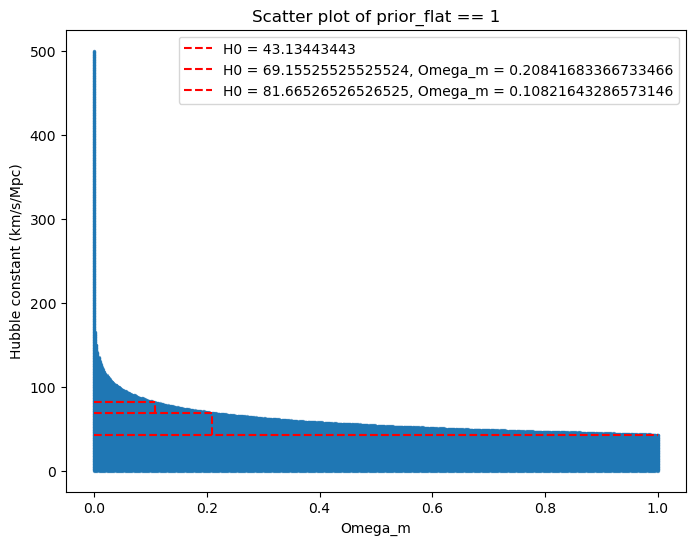

In [ ]:

# Hubble0와 omegam은 prior_flat의 축과 일치해야 합니다.
# prior_flat이 1인 위치의 인덱스를 찾음
idx = np.where(prior_flat == 1)

# x축: omegam, y축: Hubble0
plt.figure(figsize=(8, 6))
plt.scatter(M_Flat[idx], H_Flat[idx], s=2, alpha=0.5)
plt.hlines(y=43.13443443,xmin=0.0, xmax = 1, color='red', linestyle='--', linewidth=1.5, label = 'H0 = 43.13443443')
plt.hlines(y=69.15525525525524, xmin = 0.0, xmax = 0.20841683366733466, color='red', linestyle='--', linewidth=1.5, label = 'H0 = 69.15525525525524, Omega_m = 0.20841683366733466')
plt.vlines(x = 0.20841683366733466, ymin = 43.13443443, ymax = 69.15525525525524, color='red', linestyle='--', linewidth=1.5)
plt.hlines(y=81.66526526526525,xmin = 0.0, xmax =0.10821643286573146,  color='red', linestyle='--', linewidth=1.5, label = 'H0 = 81.66526526526525, Omega_m = 0.10821643286573146')
plt.vlines(x = 0.10821643286573146, ymin = 69.15525525525524, ymax = 81.66526526526525, color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Omega_m')
plt.ylabel('Hubble constant (km/s/Mpc)')
plt.title('Scatter plot of prior_flat == 1')
plt.legend()
plt.show()

Prior_flat1 : 0< Hubble constant < 43.13443443, 0 < Omega_m < 1

Prior_flat2 : 43.13443443 < Hubble constant < 69.15525525525524, 0 < Omega_m < 0.20841683366733466

Prior_flat3 : 69.15525525525524 < Hubble constant < 81.66526526526525, 0 < Omega_m < 0.10821643286573146

## 1-2. Curved LCDM prior

In [5]:
# Calculate the prior for Curved LCDM
omegam = np.linspace(0.0, 20, 100)
omegalamb = np.linspace(-3, 3, 100)
Hubble0 = np.linspace(0.1,80,100)
H, M, L = np.meshgrid(Hubble0, omegam, omegalamb)
prior_curved = np.zeros(M.shape)
age = AgeofUniverse(H,M, L)
prior_curved[age >= 15] = 1
np.save('prior_curved.npy', prior_curved)

/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_12810/1870852958.py:8: RuntimeWarning: invalid value encountered in sqrt
  y = np.sqrt(y2)


In [8]:
omegam = np.linspace(0.0, 20, 100)
omegalamb = np.linspace(-3, 3, 100)
Hubble0 = np.linspace(0.1,80,100)
H, M, L = np.meshgrid(Hubble0, omegam, omegalamb)
prior_curved = np.load('prior_curved.npy')

Prior = 0 < Hubble0 < 38.032323232323236


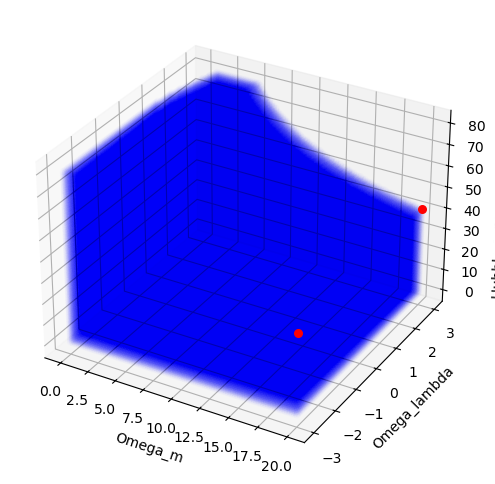

In [10]:
# ...existing code...
idx = np.where(prior_curved == 1)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

# 파란 점(전체 prior)을 먼저 plot (맨 뒤로)
blue = ax.scatter(M[idx], L[idx], H[idx], c='b', marker='o', alpha=0.01, zorder=1)

# 조건별로 노란/빨간 점을 나중에 plot (맨 앞으로)
red_points = []
yellow_points = []

cond1 = np.where((M == 0) & (L == 3) & (prior_curved == 1))
if cond1[0].size > 0:
    red_points.append(ax.scatter(M[cond1][-1], L[cond1][-1], H[cond1][-1], color='red', s=30, zorder=10))

cond2 = np.where((M ==20) & (L == 3) & (prior_curved == 1))
if cond2[0].size > 0:
    red_points.append(ax.scatter(M[cond2][-1], L[cond2][-1], H[cond2][-1], color='red', s=30, zorder=10))
cond3 = np.where((M == 20) & (L == -3) & (prior_curved == 1))
if cond3[0].size > 0:
    red_points.append(ax.scatter(M[cond3][-1], L[cond3][-1], H[cond3][-1], color='red', s=30, zorder=10))
"""
cond4 = np.where((M >= 0.2) & (M < 0.22) &(L == 1)& (prior_curved == 1))
if cond4[0].size > 0:
    yellow_points.append(ax.scatter(M[cond4][-1], L[cond4][-1], H[cond4][-1], color='yellow', s=30, zorder=20)) 
cond5 = np.where((H >= 75.23) & (H < 75.33) &(M == 0)& (prior_curved == 1))
if cond5[0].size > 0:
    yellow_points.append(ax.scatter(M[cond5][0], L[cond5][0], H[cond5][0], color='yellow', s=30, zorder=20))
    
cond6 = np.where((M >= 0.1) & (M < 0.11) &(L == 1)& (prior_curved == 1))
if cond6[0].size > 0:
    yellow_points.append(ax.scatter(M[cond6][-1], L[cond6][-1], H[cond6][-1], color='green', s=30, zorder=20))
cond7 = np.where((H > 89.26052104) & (M == 0) & (prior_curved == 1))
if cond7[0].size > 0:
    yellow_points.append(ax.scatter(M[cond7][0], L[cond7][0], H[cond7][0], color='green', s=30, zorder=20))

# zorder를 강제로 재할당 (matplotlib은 3D에서 zorder가 완벽히 동작하지 않을 수 있으나, 이 방식이 최선)
"""
for artist in red_points:
    artist.set_zorder(10)
#for artist in yellow_points:
#    artist.set_zorder(20)
blue.set_zorder(1)

ax.set_xlabel('Omega_m')
ax.set_ylabel('Omega_lambda')
ax.set_zlabel('Hubble constant (km/s/Mpc)')

print(f'Prior = 0 < Hubble0 < {H[cond3][-1]}')
#print(f'Prior_2 = {H[cond1][-1]} < Hubble0 < {H[cond4][-1]}, 0 < Omega_m < {M[cond4][-1]}, {L[cond5][0]} < Omegalamb < {L[cond4][-1]}')
#print(f'Prior_3 = {H[cond4][-1]} < Hubble0 < {H[cond6][-1]}, 0 < Omega_m < {M[cond6][-1]}, {L[cond7][0]} < Omegalamb < {L[cond6][-1]}')""
plt.show()

In [ ]:
H[cond3][-1]

34.95230460921844

## 1-3 Prior from GW data

We will use GW data, which is relatively in small redshifts, to get a rough estimate of the prior.

To do so, we will use an approximate relaltion for the current proper distance & calculate luminosity distance with it.

$$ d_p(t_0) \approx \cfrac{cz}{H_0}$$

In [ ]:
# GW data
z_GW = np.array([0.0101,0.0067])
dl_GW = np.array([150.9, 95.4]) # Mpc
ddl_GW = np.array([14,14.5])

In [ ]:
def propdist_approx(z,H0):
    # Approximate the luminosity distance for small redshifts
    c = 299792.458  # speed of light in km/s
    dp = c*z/H0
    dl = (1+z)*dp
    return dl

In [ ]:
from scipy.optimize import curve_fit

gwpopt, gwpcov = curve_fit(propdist_approx, z_GW, dl_GW, sigma=ddl_GW, absolute_sigma=True)
print("Flat LCDM fit parameters (H0, omegam):", gwpopt)
print("Flat LCDM fit covariance matrix:\n", gwpcov)

Flat LCDM fit parameters (H0, omegam): [20.52832336]
Flat LCDM fit covariance matrix:
 [[2.64373053]]


Prior_final : 4.66594018 < H0 < 36.39070654 $$({H0_{avg}} \pm 6\sigma_{H0})$$

# 2. Prepare for MCMC

## 2-1. Supernovae data:

$$M_B ≈ M_V ≈ −19.30 ± 0.03 + 5 \log(H_0/60) \qquad \text{Hillebrandt, W.; Niemeyer, J. C. (2000)}$$

$$\text{we will calculate} \ \log(d_L) \text{ with distance modulus } m - M = 5\log (d_L) + 25$$
-> fit the log(d_L) with cosmological parameters


In [85]:

# observed data
mb = sndata['mb'].values
dmb = sndata['dmb'].values
z = sndata['zcmb'].values

In [86]:
def dL_SN_Obs(mb, dmb, H0): # calculate luminosity distance from observed data with the distance modulus

    absmb = -19.3 + 5*np.log10(H0/60) # H0 in km/s/Mpc
    dabsmb = 0.03
    logdl_obs = (mb - absmb - 25)/5 
    dlogdl_obs = (dmb + dabsmb)/5
    return logdl_obs, dlogdl_obs

### 2 - 1 - 1 : Flat LCDM

In [87]:
# calculated data via the model

# model parameters
# 1. Flat Lambda CDM
def E_inverse_flat(z, Omega_m): # return 1/E(z) = H0/H(z)
    Omega_L = 1 - Omega_m
    E = np.sqrt(Omega_m*(1+z)**3 + Omega_L)
    return 1/E

def Flat_LCDM(z_arr, parm): # parm[0] = H0, parm[1] = Omegam,
    """_summary_

    Args:
        z (redshift): The redshift parameter.
        H0 (float): The Hubble constant in km/s/Mpc.
        Omega_m (float): The matter density parameter.

    Returns:
        float: The log Luminosity distance at redshift z in Mpc.
    """
    H0, Omegam = parm
    c = 299792.458
    dp = np.array([c*1/H0* quad_vec(E_inverse_flat, 0, z, args=(Omegam))[0] for z in z_arr])
    dl = (1+z_arr)*dp
    logdl = np.log10(dl)
    return logdl

In [88]:
from tqdm import tqdm

# 1. make a code that accounts for a prior
def ln_prior(min,max):
    volume = np.prod(np.abs(min - max)) # volume of the prior
    return np.log(1/volume)

def Loglikelihood(func, parm,z): # return Loglikelihood = -chisq, parm[0] = H0, parm[1] = Omegam, parm[2] = Omegalamb
    H0 = parm[0]
    y0 = dL_SN_Obs(mb, dmb, H0)[0]
    var = dL_SN_Obs(mb, dmb, H0)[1]**2
    diff = (y0 - func(z,parm))**2
    chisq = np.sum(diff/var)
    return -chisq

def ln_f(func, parm,z, prior, lnprior): # return total Loglikelihood
    bool = np.all((prior[0] <= parm) & (parm <= prior[1]))
    if bool == True:
        return lnprior + Loglikelihood(func, parm, z) # param[0] = H0, param[1] = Omegam, param[2] = Omegalamb
    else:
        return -np.inf

def Markov(func, paramk,paramkp1,z, prior, lnprior):
    minuschisqk = ln_f(func, paramk, z, prior, lnprior)
    minuschisqkp1 = ln_f(func, paramkp1, z, prior, lnprior)
    lnr = np.log(np.random.uniform(0.,1.))

    if minuschisqkp1 - minuschisqk > lnr:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : True")
        return paramkp1, minuschisqkp1
    else:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : False")
        return paramk, minuschisqk

def MCMC(func, paraminit,z, nstep,normal_vec,prior): # param0 = [H0, Omegam, Omegalamb]
    lnprior = ln_prior(prior[0], prior[1]) # calculate the prior volume likelihood
    param0 = paraminit
    arr = np.zeros((len(param0) + 1,nstep))
    stepsize = normal_vec
    for k in tqdm(range(nstep)):
        paramkp1 = np.array(param0 + np.random.normal(0,stepsize))
        param0, loglikelihood = Markov(func, param0, paramkp1, z, prior, lnprior) #loglikelihood = -chisq
        col = np.hstack((param0, loglikelihood))
        arr[:,k] = col
    return arr

In [89]:
Prior1 = np.array([[4.66594018,0], [36.39070654, 1]])

In [117]:
nstep = 1000
normal_vec = np.array([2.16656036e-01, 8.47071452e-06])*10
std = np.array([0.25058526, 0.001])
paraminit = np.array([17.559485514552893, 1.5139296621150994e-08]) + np.random.normal(0,std)
MCMC_test = MCMC(Flat_LCDM, paraminit, z, nstep, normal_vec, Prior1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:35<00:00,  6.43it/s]


accept_ratio = 0.33375
Best_fit = Omega_m : 7.868486454590728e-07, Hubble_constant : 15.141026332713572
std = [5.51095745e+00 1.00290520e-05]


Text(0.5, 1.0, 'MCMC result for Flat LCDM')

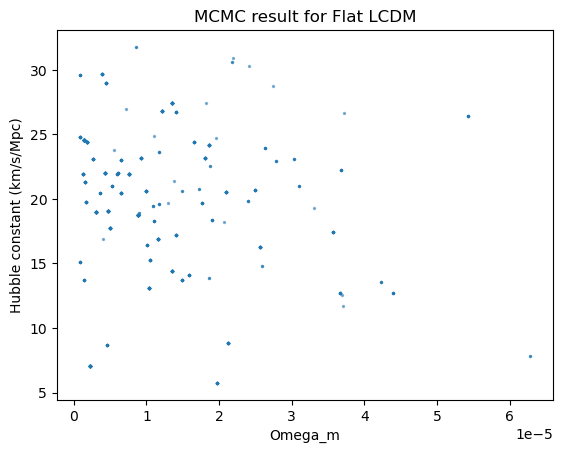

In [118]:
MCMC_test = MCMC_test[:,200:]
accept_ratio = np.unique(MCMC_test).shape[0] / (nstep-200)
Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0:2], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[1]}, Hubble_constant : {Best_fit[0]}')
print(f'std = {std}')
plt.scatter(MCMC_test[1], MCMC_test[0], s=2, alpha=0.5)
plt.xlabel('Omega_m')
plt.ylabel('Hubble constant (km/s/Mpc)')
plt.title('MCMC result for Flat LCDM')

In [ ]:
# Real MCMC run
normal_vec = np.array([2.16656036e-01, 8.47071452e-06])*10
std = np.array([5.51095745e+00, 1.00290520e-05])
paraminit = np.array([15.141026332713572, 7.868486454590728e-07]) + np.random.normal(0,std)
nstep = int(1e5 + 2*1e4)
MCMC_fin = MCMC(Flat_LCDM, paraminit, z, nstep, normal_vec, Prior1)
np.save('MCMC_fin.npy', MCMC_fin)

  0%|                                                                                                                                                                     | 0/120000 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:02<00:00, 59899.72it/s]


In [ ]:
MCMC_fin.shape

(3, 120000)

accept_ratio = 0.19688135593220338
Best_fit = Omega_m : 1.308223974766749e-10, Hubble_constant : 34.40528955968031
std = [1.23072240e-01 5.65815608e-07]


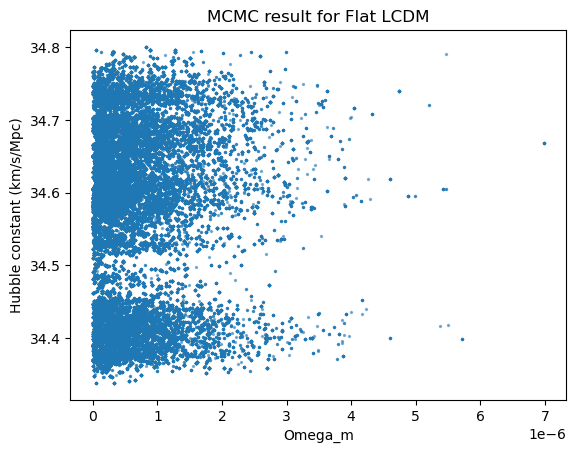

In [ ]:
MCMC_fin = np.load('MCMC_fin_SN_flat.npy')
MCMC_fin = MCMC_fin[:,2000:]
accept_ratio = np.unique(MCMC_fin).shape[0] / (nstep-2000)
Best_fit = MCMC_fin[:,np.argmax(MCMC_fin[-1])]
std = np.std(MCMC_fin[0:2], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[1]}, Hubble_constant : {Best_fit[0]}')
print(f'std = {std}')
plt.scatter(MCMC_fin[1], MCMC_fin[0], s=2, alpha=0.5)
plt.xlabel('Omega_m')
plt.ylabel('Hubble constant (km/s/Mpc)')
plt.title('MCMC result for Flat LCDM')
plt.savefig('MCMC_flat_SN_result.png')

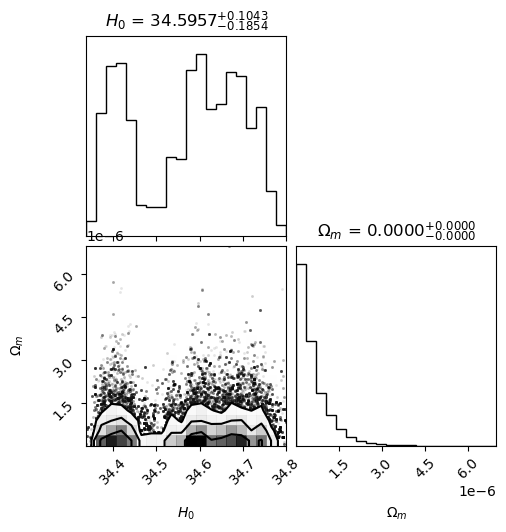

In [ ]:
import corner

# MCMC_fin에서 파라미터(H0, Omega_m)만 추출 (loglikelihood 제외)
samples = MCMC_fin[:2].T  # shape: (샘플 수, 2)

figure = corner.corner(
    samples,
    labels=[r"$H_0$", r"$\Omega_m$"],
    show_titles=True,
    title_fmt=".4f",
    title_kwargs={"fontsize": 12}
)
plt.show()

### 2 - 1 - 2 : Curved LCDM

In [ ]:
def E_inverse_curved(z, Omega_m, Omega_L): # return 1/E(z) = H0/H(z)
    Omega0 = Omega_L + Omega_m
    E = np.sqrt(Omega_m*(1+z)**3 + Omega_L + (1-Omega0)*(1+z)**2)
    return 1/E

def Curved_LCDM(z_arr, parm): 
    """_summary_

    Args:
        z (redshift): The redshift parameter.
        parm (array): The parameters for the model.
        parm[0] = H0, parm[1] = Omegam, parm[2] = Omegalamb

    Returns:
        float: The log Luminosity distance at redshift z in Mpc.
    """
    c = 299792.458
    H0 = parm[0]; Omega_m = parm[1]; Omega_L = parm[2]
    Omega0 = Omega_L + Omega_m
    R_k = 1/np.sqrt(np.abs(Omega0 - 1))
    # Integrate the integrand over the redshift range
    if Omega0 == 1:
        dp = np.array([c*1/H0* quad_vec(E_inverse_curved, 0, z, args=(Omega_m, Omega_L))[0] for z in z_arr])
    elif Omega0 < 1: # Open universe
        dp = np.array([c*R_k/H0* np.sinh(quad_vec(E_inverse_curved, 0, z, args=(Omega_m, Omega_L))[0]/R_k) for z in z_arr])
    else: # Closed universe
        dp = np.array([c*R_k/H0* np.sin(quad_vec(E_inverse_curved, 0, z, args=(Omega_m, Omega_L))[0]/R_k) for z in z_arr])
    dl = (1+z_arr)*dp
    logdl = np.log10(dl)
    return logdl


In [ ]:
Prior2 = np.array([[4.66594018,0,0], [34.95230460921844, 2.5,2.5]])

In [ ]:
nstep = 2000
normal_vec = np.array([0.03930708, 0.00039732, 0.00066281])*2
std = np.array([0.03930708, 0.00039732, 0.00066281])
paraminit = np.array([34.92591854818404, 0.13624172280017455,1.4100293561949133]) + np.random.normal(0,std)
MCMC_test = MCMC(Curved_LCDM, paraminit, z, nstep, normal_vec, Prior2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [11:13<00:00,  2.97it/s]


In [ ]:
# only for testing

nstep = 2000
normal_vec = np.array([0.13072321, 0.00093998, 0.00136736])
std = np.array([1, 9.46179403e-04, 1.58853578e-03])
paraminit = np.array([20, 0.14046191865207613,1.4167892770111263]) + np.random.normal(0,std)
MCMC_test = MCMC(Curved_LCDM, paraminit, z, nstep, normal_vec, Prior2)

100%|██████████████████████████████████████| 2000/2000 [06:30<00:00,  5.12it/s]


In [ ]:
MCMC_test = MCMC_test[:,800:]
accept_ratio = np.unique(MCMC_test).shape[0] / (nstep-800)
Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0:3], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Hubble constant : {Best_fit[0]}, Omega m : {Best_fit[1]}, Omega_lambda : {Best_fit[2]}')
print(f'std = {std}')

accept_ratio = 0.21
Best_fit = Hubble constant : 21.52781056660224, Omega m : 0.14057682138731173, Omega_lambda : 1.4171280185208635
std = [0.19676278 0.00062626 0.00100744]


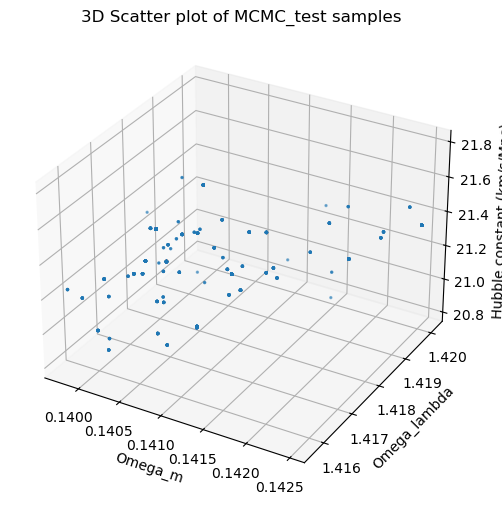

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# MCMC_test[0]: H0, MCMC_test[1]: Omega_m, MCMC_test[2]: Omega_lambda
ax.scatter(MCMC_test[1], MCMC_test[2], MCMC_test[0], s=2, alpha=0.5)

ax.set_xlabel('Omega_m')
ax.set_ylabel('Omega_lambda')
ax.set_zlabel('Hubble constant (km/s/Mpc)')
ax.set_title('3D Scatter plot of MCMC_test samples')

plt.show()

In [ ]:
#Real MCMC run
nstep = int(1e5 + 2*1e4)
normal_vec = np.array([0.03930708, 0.00039732, 0.00066281])*2
std = np.array([0.03930708, 0.00039732, 0.00066281])
paraminit = np.array([34.92591854818404, 0.13624172280017455,1.4100293561949133]) + np.random.normal(0,std)
MCMC_fin_curved = MCMC(Curved_LCDM, paraminit, z, nstep, normal_vec, Prior2)
np.save('MCMC_fin_curved.npy', MCMC_fin_curved)

 10%|█████████████████████▎                                                                                                                                                                                       | 12444/120000 [1:13:29<9:36:01,  3.11it/s]/tmp/ipykernel_2826/1087390749.py:29: RuntimeWarning: invalid value encountered in log10
  logdl = np.log10(dl)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [11:54:16<00:00,  2.80it/s]


accept_ratio = 0.20530201342281879
Best_fit = Hubble constant : 28.01754811088701, Omega m : 0.14068429066062024, Omega_lambda : 1.4172843766244256
std = [2.06960324e+00 4.82321138e-04 7.96047451e-04]


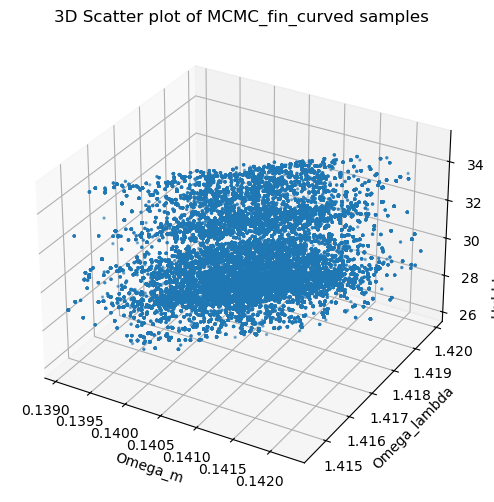

In [ ]:
MCMC_fin_curved = np.load('MCMC_fin_SN_curved.npy')
MCMC_fin_curved = MCMC_fin_curved[:,800:]
nstep = int(1e5 + 2*1e4)
accept_ratio = np.unique(MCMC_fin_curved).shape[0] / (nstep-800)
Best_fit = MCMC_fin_curved[:,np.argmax(MCMC_fin_curved[-1])]
std = np.std(MCMC_fin_curved[0:3], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Hubble constant : {Best_fit[0]}, Omega m : {Best_fit[1]}, Omega_lambda : {Best_fit[2]}')
print(f'std = {std}')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# MCMC_fin_curved[0]: H0, MCMC_fin_curved[1]: Omega_m, MCMC_fin_curved[2]: Omega_lambda
ax.scatter(MCMC_fin_curved[1], MCMC_fin_curved[2], MCMC_fin_curved[0], s=2, alpha=0.5)

ax.set_xlabel('Omega_m')
ax.set_ylabel('Omega_lambda')
ax.set_zlabel('Hubble constant (km/s/Mpc)')
ax.set_title('3D Scatter plot of MCMC_fin_curved samples')

plt.show()

In [ ]:
#Real MCMC run 2
nstep = int(1e5 + 2*1e4)
normal_vec = np.array([0.13072321, 0.00093998, 0.00136736])
std = np.array([0.19676278, 0.00062626, 0.00100744])
paraminit = np.array([21.52781056660224, 0.14057682138731173,1.4171280185208635]) + np.random.normal(0,std)
MCMC_fin_curved2 = MCMC(Curved_LCDM, paraminit, z, nstep, normal_vec, Prior2)
np.save('MCMC_fin_curved2.npy', MCMC_fin_curved2)

(4, 119200)

In [ ]:
MCMC_fin_curved2 = np.load('MCMC_fin_curved2.npy')
MCMC_fin_curved2 = MCMC_fin_curved2[:,800:]
nstep = int(1e5 + 2*1e4)
accept_ratio = np.unique(MCMC_fin_curved2).shape[0] / (nstep-800)
Best_fit = MCMC_fin_curved2[:,np.argmax(MCMC_fin_curved2[-1])]
std = np.std(MCMC_fin_curved2[0:3], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Hubble constant : {Best_fit[0]}, Omega m : {Best_fit[1]}, Omega_lambda : {Best_fit[2]}')
print(f'std = {std}')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# MCMC_fin_curved[0]: H0, MCMC_fin_curved[1]: Omega_m, MCMC_fin_curved[2]: Omega_lambda
ax.scatter(MCMC_fin_curved2[1], MCMC_fin_curved2[2], MCMC_fin_curved2[0], s=2, alpha=0.5)

ax.set_xlabel('Omega_m')
ax.set_ylabel('Omega_lambda')
ax.set_zlabel('Hubble constant (km/s/Mpc)')
ax.set_title('3D Scatter plot of MCMC_fin_curved samples')

plt.show()

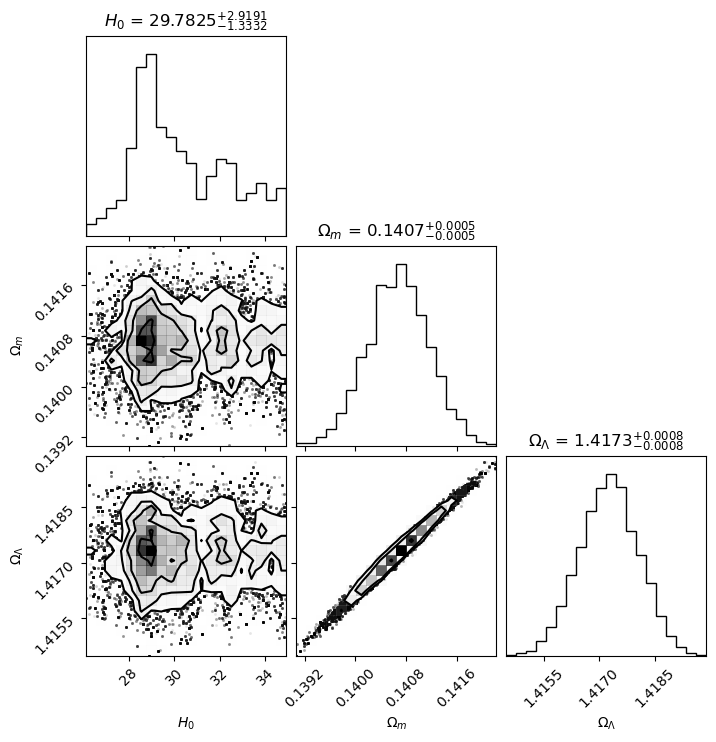

In [ ]:
import corner

# MCMC_fin에서 파라미터(H0, Omega_m)만 추출 (loglikelihood 제외)
samples = MCMC_fin_curved[:3].T  # shape: (샘플 수, 2)

figure = corner.corner(
    samples,
    labels=[r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"],
    show_titles=True,
    title_fmt=".4f",
    title_kwargs={"fontsize": 12}
)
plt.show()

## 2-2. SN + BAO data

BAO data consists of 
$$D_V(z) = \left[\cfrac{cz}{H_0}\cfrac{D_M^2(z)}{E(z)} \right]^{1/3}$$
$$D_M(z) = d_p(z)$$
$$R_{eq} = 3\rho_{eq}/4\rho_{rad} \approx \cfrac{3}{4} \cfrac{\Omega_{b,0}h^2}{1.48\times10^{-6}}\cfrac{1}{1+z_{eq}}$$
$$f_{baryon} = \cfrac{\Omega_{b,0}}{\Omega_{m,0}} = 0.167$$
$$z_{rec} \approx 2426.3839 \ (\text{Calculated using CAMB}) $$
$$1+z_{eq} = \cfrac{\Omega_{m,0}}{\Omega_{rad,0}} = \cfrac{\Omega_{m,0}h^2}{1.48\times10^{-6}}$$

We calculate the $r_{d,fid}$ with the following equation.
$$r_{d,fid} = \cfrac{1}{\sqrt{\Omega_{m,0}H_0^2}}\cfrac{2c}{\sqrt{3z_{eq}R_{eq}}}\ln\left[\cfrac{\sqrt{1+R_{rec}} + \sqrt{R_{rec} + R_{eq}}}{1 + \sqrt{R_{eq}}}\right]$$

In [119]:
# BAO data
BAO_z = np.array([0.01115,0.157,0.389,0.389,0.536,0.536,0.626,0.626])
BAO_val = np.array([0.08,1906.18,3905.35,43.56,4761.80,50.83,5175.36,57.19])
BAO_err = np.array([0.003,66.577,58.667,1.310,68.866,1.531,77.639,1.336])
BAO_ind = np.array([1,2,3,4,3,4,3,4]) # 1 : r_s/D_V, 2 : D_V(r_d,fid/r_d), 3 : D_M(r_d,fid/r_d), 4 : H(r_d/r_d,fid)

BAO_data = pd.DataFrame({
    'z': BAO_z,
    'val': BAO_val,
    'err': BAO_err,
    'ind': BAO_ind
})

### 2-2-1 : Flat LCDM

In [120]:
# observed data
mb = sndata['mb'].values
dmb = sndata['dmb'].values
z = sndata['zcmb'].values

def dL_SN_Obs(mb, dmb, H0): # calculate luminosity distance from observed data with the distance modulus

    absmb = -19.3 + 5*np.log10(H0/60) # H0 in km/s/Mpc
    dabsmb = 0.03
    logdl_obs = (mb - absmb - 25)/5 
    dlogdl_obs = (dmb + dabsmb)/5
    return logdl_obs, dlogdl_obs

# calculated data via the model

# Distances
# 1. Flat Lambda CDM
def E_inverse_flat(z, Omega_m): # return 1/E(z) = H0/H(z)
    Omega_L = 1 - Omega_m
    E = np.sqrt(Omega_m*(1+z)**3 + Omega_L)
    return 1/E

def Flat_LCDM(z_arr, parm): # parm[0] = H0, parm[1] = Omegam,
    """_summary_

    Args:
        z (redshift): The redshift parameter.
        H0 (float): The Hubble constant in km/s/Mpc.
        Omega_m (float): The matter density parameter.

    Returns:
        float: The log Luminosity distance at redshift z in Mpc.
    """
    H0, Omegam = parm
    c = 299792.458
    dp = np.array([c*1/H0* quad_vec(E_inverse_flat, 0, z, args=(Omegam))[0] for z in z_arr])
    dl = (1+z_arr)*dp
    logdl = np.log10(dl)
    return logdl
def D_M_flat(z_arr, parm): # Proper distance
    H0, Omegam = parm
    c = 299792.458
    dp = np.array([c*1/H0* quad_vec(E_inverse_flat, 0, z, args=(Omegam))[0] for z in z_arr])
    return dp

def H_flat(z_arr, parm): # Hubble parameter
    H0, Omegam = parm
    c = 299792.458
    Hz = H0 * np.sqrt(Omegam*(1+z_arr)**3 + (1-Omegam))
    return Hz
def D_V_flat(z_arr, parm): # Volume-averaged angular diameter distance
    c = 299792.458
    D_M = D_M_flat(z_arr, parm)
    Hz = H_flat(z_arr, parm)
    D_V = (c*z_arr/Hz*D_M**2)**(1/3)
    return D_V
def z_eq(parm): # equality redshift -> varied for parm, only H0 and Omegam
    H0, Omegam = parm
    h = H0/100
    z_eq = Omegam*h**2/(1.48*10**(-6))
    return z_eq
def R_eq(parm):
    z_eqs = z_eq(parm)
    f_baryon = 0.167
    R_eq = 3.4*f_baryon*z_eqs/(1+z_eqs)
    return R_eq
def R_rec(parm): # recombination redshift
    z_rec = 2784
    f_baryon = 0.167
    z_eqs = z_eq(parm)
    R_rec = 3.4*f_baryon*z_eqs/(1+z_rec)
    return R_rec
def r_dfid(parm): # fiducial sound horizon
    c = 299792.458
    H0, Omegam = parm
    z_eqs = z_eq(parm);R_eqs = R_eq(parm);R_recs = R_rec(parm)
    first_term = 1/np.sqrt(Omegam*H0**2)
    second_term = 2*c/np.sqrt(3*z_eqs*R_eqs)
    log_term = np.log((np.sqrt(1+R_recs) + np.sqrt(R_recs+R_eqs))/(1+np.sqrt(R_eqs)))
    r_d = first_term*second_term*log_term
    return r_d

def BAO_flat(parm, z, ind):
    c = 299792.458
    r_dfids = r_dfid(parm)
    r_d = 101.19
    result = np.zeros(len(z))
    # type 1 : r_d/D_V
    ind1 = np.where(ind == 1)
    z1 = z[ind1]
    D_V = D_V_flat(z1, parm)
    result[ind1] = r_dfids/D_V
    # type 2 : D_V(r_dfid/r_d)
    ind2 = np.where(ind == 2)
    z2 = z[ind2]
    D_V = D_V_flat(z2, parm)
    result[ind2] = D_V*r_dfids/r_d
    # type 3 : D_M(r_dfid/r_d)
    ind3 = np.where(ind == 3)
    z3 = z[ind3]
    D_M = D_M_flat(z3, parm)
    result[ind3] = D_M*r_dfids/r_d
    # type 4 : H(r_d/r_dfid)
    ind4 = np.where(ind == 4)
    z4 = z[ind4]
    H = H_flat(z4, parm)
    result[ind4] = H*r_d/r_dfids
    return result




In [121]:
from tqdm import tqdm

# 1. make a code that accounts for a prior
def ln_prior(min,max):
    volume = np.prod(np.abs(min - max)) # volume of the prior
    return np.log(1/volume)

def Loglikelihood(func, parm,z): # return Loglikelihood = -chisq, parm[0] = H0, parm[1] = Omegam, parm[2] = Omegalamb
    H0 = parm[0]
    y0_SN = dL_SN_Obs(mb, dmb, H0)[0]
    var_SN = dL_SN_Obs(mb, dmb, H0)[1]**2
    diff_SN = (y0_SN - func(z,parm))**2
    chisq_SN = np.sum(diff_SN/var_SN)
    return -chisq_SN
def BAO_loglikelihood(func, parm, BAO_data): # return Loglikelihood = -chisq
    z = BAO_data['z'].values
    val = BAO_data['val'].values
    err = BAO_data['err'].values
    BAO_ind = BAO_data['ind'].values
    y0_BAO = val
    var_BAO = err**2
    diff_BAO = (y0_BAO - func(parm, z, BAO_ind))**2
    chisq_BAO = np.sum(diff_BAO/var_BAO)
    return -chisq_BAO

def ln_f(func, parm,z,BAO_data, prior, lnprior): # return total Loglikelihood
    bool = np.all((prior[0] <= parm) & (parm <= prior[1]))
    if bool == True:
        return (
    lnprior + Loglikelihood(func, parm, z) + BAO_loglikelihood(BAO_flat, parm, BAO_data)
         ) # param[0] = H0, param[1] = Omegam, param[2] = Omegalamb
    else:
        return -np.inf

def Markov(func, paramk,paramkp1,z,BAO_data, prior, lnprior):
    minuschisqk = ln_f(func, paramk, z,BAO_data, prior, lnprior)
    minuschisqkp1 = ln_f(func, paramkp1, z,BAO_data, prior, lnprior)
    lnr = np.log(np.random.uniform(0.,1.))

    if minuschisqkp1 - minuschisqk > lnr:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : True")
        return paramkp1, minuschisqkp1
    else:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : False")
        return paramk, minuschisqk

def MCMC_BAO(func, paraminit,z,BAO_data,nstep,normal_vec,prior): # param0 = [H0, Omegam, Omegalamb]
    lnprior = ln_prior(prior[0], prior[1]) # calculate the prior volume likelihood
    param0 = paraminit
    arr = np.zeros((len(param0) + 1,nstep))
    stepsize = normal_vec
    for k in tqdm(range(nstep)):
        paramkp1 = np.array(param0 + np.random.normal(0,stepsize))
        param0, loglikelihood = Markov(func, param0, paramkp1, z,BAO_data, prior, lnprior) #loglikelihood = -chisq
        col = np.hstack((param0, loglikelihood))
        arr[:,k] = col
    return arr

In [122]:
Prior1 = np.array([[4.66594018,0], [36.39070654, 1]])

In [125]:
""""""
normal_vec = np.array([1., 1.37753013e-01])*0.3
std = np.array([2.07756520e+00, 1.37753013e-03])
paraminit = np.array([34, 0.12]) + np.random.normal(0,std)
nstep = int(1000)
MCMC_test = MCMC_BAO(Flat_LCDM, paraminit, z,BAO_data, nstep, normal_vec, Prior1)
""""""

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:16<00:00,  5.09it/s]


''

accept_ratio = 0.08625
Best_fit = Omega_m : 0.8006731016158654, Hubble_constant : 29.16815409978608
std = [0.07754899 0.00263407]


''

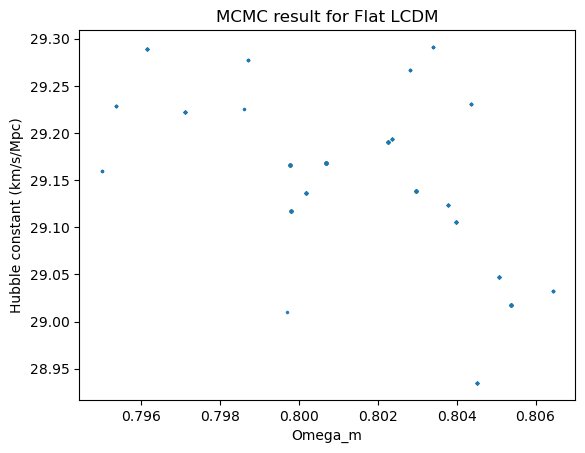

In [126]:
""""""
MCMC_test = MCMC_test[:,200:]
accept_ratio = np.unique(MCMC_test).shape[0] / (nstep-200)
Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0:2], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[1]}, Hubble_constant : {Best_fit[0]}')
print(f'std = {std}')
plt.scatter(MCMC_test[1], MCMC_test[0], s=2, alpha=0.5)
plt.xlabel('Omega_m')
plt.ylabel('Hubble constant (km/s/Mpc)')
plt.title('MCMC result for Flat LCDM')
""""""

In [48]:
# Real MCMC run
normal_vec = np.array([1, 1.37753013e-03])*0.3
std = np.array([2.07756520e+00, 1.37753013e-03])
paraminit = np.array([15.968875795254439, 0.03533638457009756]) + np.random.normal(0,std)
nstep = int(1e5 + 1.5*1e4)
MCMC_fin_BAO = MCMC_BAO(Flat_LCDM, paraminit, z, BAO_data,nstep, normal_vec, Prior1)
np.save('MCMC_fin_BAO.npy', MCMC_fin_BAO)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115000/115000 [6:02:36<00:00,  5.29it/s]


### 2-2-2 : Curved LCDM

In [ ]:
# Distances
# 2. Curved Lambda CDM
def E_inverse_curved(z, Omega_m, Omega_L): # return 1/E(z) = H0/H(z)
    Omega0 = Omega_L + Omega_m
    E = np.sqrt(Omega_m*(1+z)**3 + Omega_L + (1-Omega0)*(1+z)**2)
    return 1/E

def Curved_LCDM(z_arr, parm): 
    """_summary_

    Args:
        z (redshift): The redshift parameter.
        parm (array): The parameters for the model.
        parm[0] = H0, parm[1] = Omegam, parm[2] = Omegalamb

    Returns:
        float: The log Luminosity distance at redshift z in Mpc.
    """
    c = 299792.458
    H0 = parm[0]; Omega_m = parm[1]; Omega_L = parm[2]
    Omega0 = Omega_L + Omega_m
    R_k = 1/np.sqrt(np.abs(Omega0 - 1))
    # Integrate the integrand over the redshift range
    if Omega0 == 1:
        dp = np.array([c*1/H0* quad_vec(E_inverse_curved, 0, z, args=(Omega_m, Omega_L))[0] for z in z_arr])
    elif Omega0 < 1: # Open universe
        dp = np.array([c*R_k/H0* np.sinh(quad_vec(E_inverse_curved, 0, z, args=(Omega_m, Omega_L))[0]/R_k) for z in z_arr])
    else: # Closed universe
        dp = np.array([c*R_k/H0* np.sin(quad_vec(E_inverse_curved, 0, z, args=(Omega_m, Omega_L))[0]/R_k) for z in z_arr])
    dl = (1+z_arr)*dp
    logdl = np.log10(dl)
    return logdl
def D_M_curved(z_arr, parm): # Proper distance
    H0, Omegam, Omega_L = parm
    c = 299792.458
    Omega0 = Omega_L + Omegam
    R_k = 1/np.sqrt(np.abs(Omega0 - 1))
    # Integrate the integrand over the redshift range
    if Omega0 == 1:
        dp = np.array([c*1/H0* quad_vec(E_inverse_curved, 0, z, args=(Omegam, Omega_L))[0] for z in z_arr])
    elif Omega0 < 1: # Open universe
        dp = np.array([c*R_k/H0* np.sinh(quad_vec(E_inverse_curved, 0, z, args=(Omegam, Omega_L))[0]/R_k) for z in z_arr])
    else: # Closed universe
        dp = np.array([c*R_k/H0* np.sin(quad_vec(E_inverse_curved, 0, z, args=(Omegam, Omega_L))[0]/R_k) for z in z_arr])
    return dp

def H_curved(z_arr, parm): # Hubble parameter
    H0, Omegam, Omega_L = parm
    Omega0 = Omega_L + Omegam
    c = 299792.458
    Hz = H0 * np.sqrt(Omegam*(1+z_arr)**3 + Omega_L + (1-Omega0)*(1+z_arr)**2)
    return Hz
def D_V_curved(z_arr, parm): # Volume-averaged angular diameter distance
    c = 299792.458
    D_M = D_M_curved(z_arr, parm)
    Hz = H_curved(z_arr, parm)
    D_V = (c*z_arr/Hz*D_M**2)**(1/3)
    return D_V


def z_eq(parm): # equality redshift -> varied for parm, only H0 and Omegam
    H0, Omegam,Omegalamb = parm
    h = H0/100
    z_eq = Omegam*h**2/(1.48*10**(-6))
    return z_eq
def R_eq(parm):
    z_eqs = z_eq(parm)
    f_baryon = 0.167
    R_eq = 3.4*f_baryon*z_eqs/(1+z_eqs)
    return R_eq
def R_rec(parm): # recombination redshift
    z_rec = 2784
    f_baryon = 0.167
    z_eqs = z_eq(parm)
    R_rec = 3.4*f_baryon*z_eqs/(1+z_rec)
    return R_rec
def r_dfid(parm): # fiducial sound horizon
    c = 299792.458
    H0, Omegam, Omegalamb = parm
    z_eqs = z_eq(parm);R_eqs = R_eq(parm);R_recs = R_rec(parm)
    first_term = 1/np.sqrt(Omegam*H0**2)
    second_term = 2*c/np.sqrt(3*z_eqs*R_eqs)
    log_term = np.log((np.sqrt(1+R_eqs) + np.sqrt(R_recs+R_eqs))/(1+np.sqrt(R_eqs)))
    r_dfid = first_term*second_term*log_term
    return r_dfid

def BAO_curved(parm, z, ind):
    c = 299792.458
    r_d = 101.19
    r_dfids = r_dfid(parm)
    result = np.zeros(len(z))
    # type 1 : r_d/D_V
    ind1 = np.where(ind == 1)
    z1 = z[ind1]
    D_V = D_V_curved(z1, parm)
    result[ind1] = r_dfids/D_V
    # type 2 : D_V(r_dfid/r_d)
    ind2 = np.where(ind == 2)
    z2 = z[ind2]
    D_V = D_V_curved(z2, parm)
    result[ind2] = D_V*r_dfids/r_d
    # type 3 : D_M(r_dfid/r_d)
    ind3 = np.where(ind == 3)
    z3 = z[ind3]
    D_M = D_M_curved(z3, parm)
    result[ind3] = D_M*r_dfids/r_d
    # type 4 : H(r_d/r_dfid)
    ind4 = np.where(ind == 4)
    z4 = z[ind4]
    H = H_curved(z4, parm)
    result[ind4] = H*r_d/r_dfids
    return result

def ln_f(func, parm,z,BAO_data, prior, lnprior): # return total Loglikelihood
    bool = np.all((prior[0] <= parm) & (parm <= prior[1]))
    if bool == True:
        return (
    lnprior + Loglikelihood(func, parm, z) + BAO_loglikelihood(BAO_curved, parm, BAO_data)
         ) # param[0] = H0, param[1] = Omegam, param[2] = Omegalamb
    else:
        return -np.inf

def Markov(func, paramk,paramkp1,z,BAO_data, prior, lnprior):
    minuschisqk = ln_f(func, paramk, z,BAO_data, prior, lnprior)
    minuschisqkp1 = ln_f(func, paramkp1, z,BAO_data, prior, lnprior)
    lnr = np.log(np.random.uniform(0.,1.))

    if minuschisqkp1 - minuschisqk > lnr:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : True")
        return paramkp1, minuschisqkp1
    else:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : False")
        return paramk, minuschisqk

def MCMC_BAO(func, paraminit,z,BAO_data,nstep,normal_vec,prior): # param0 = [H0, Omegam, Omegalamb]
    lnprior = ln_prior(prior[0], prior[1]) # calculate the prior volume likelihood
    param0 = paraminit
    arr = np.zeros((len(param0) + 1,nstep))
    stepsize = normal_vec
    for k in tqdm(range(nstep)):
        paramkp1 = np.array(param0 + np.random.normal(0,stepsize))
        param0, loglikelihood = Markov(func, param0, paramkp1, z,BAO_data, prior, lnprior) #loglikelihood = -chisq
        col = np.hstack((param0, loglikelihood))
        arr[:,k] = col
    return arr

In [50]:
Prior2 = np.array([[4.66594018,0,0], [34.95230460921844, 2.5,2.5]])

In [51]:
"""
nstep = 2000
normal_vec = np.array([0.10072321, 0.00093998, 0.00136736])
std = np.array([0.04105485, 9.46179403e-04, 1.58853578e-03])
paraminit = np.array([7.116441505186051, 0.14046191865207613,1.4167892770111263]) + np.random.normal(0,std)
MCMC_test = MCMC_BAO(Curved_LCDM, paraminit, z,BAO_data, nstep, normal_vec, Prior2)
"""

'\nnstep = 2000\nnormal_vec = np.array([0.10072321, 0.00093998, 0.00136736])\nstd = np.array([0.04105485, 9.46179403e-04, 1.58853578e-03])\nparaminit = np.array([7.116441505186051, 0.14046191865207613,1.4167892770111263]) + np.random.normal(0,std)\nMCMC_test = MCMC_BAO(Curved_LCDM, paraminit, z,BAO_data, nstep, normal_vec, Prior2)\n'

In [52]:
"""
MCMC_test = MCMC_test[:,800:]
accept_ratio = np.unique(MCMC_test).shape[0] / (nstep-800)
Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0:3], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Hubble constant : {Best_fit[0]}, Omega m : {Best_fit[1]}, Omega_lambda : {Best_fit[2]}')
print(f'std = {std}')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# MCMC_test[0]: H0, MCMC_test[1]: Omega_m, MCMC_test[2]: Omega_lambda
ax.scatter(MCMC_test[1], MCMC_test[2], MCMC_test[0], s=2, alpha=0.5)

ax.set_xlabel('Omega_m')
ax.set_ylabel('Omega_lambda')
ax.set_zlabel('Hubble constant (km/s/Mpc)')
ax.set_title('3D Scatter plot of MCMC_test samples')

plt.show()
"""

"\nMCMC_test = MCMC_test[:,800:]\naccept_ratio = np.unique(MCMC_test).shape[0] / (nstep-800)\nBest_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]\nstd = np.std(MCMC_test[0:3], axis=1)\nprint(f'accept_ratio = {accept_ratio}')\nprint(f'Best_fit = Hubble constant : {Best_fit[0]}, Omega m : {Best_fit[1]}, Omega_lambda : {Best_fit[2]}')\nprint(f'std = {std}')\nfrom mpl_toolkits.mplot3d import Axes3D\nimport matplotlib.pyplot as plt\n\nfig = plt.figure(figsize=(8, 6))\nax = fig.add_subplot(111, projection='3d')\n\n# MCMC_test[0]: H0, MCMC_test[1]: Omega_m, MCMC_test[2]: Omega_lambda\nax.scatter(MCMC_test[1], MCMC_test[2], MCMC_test[0], s=2, alpha=0.5)\n\nax.set_xlabel('Omega_m')\nax.set_ylabel('Omega_lambda')\nax.set_zlabel('Hubble constant (km/s/Mpc)')\nax.set_title('3D Scatter plot of MCMC_test samples')\n\nplt.show()\n"

In [53]:
# real MCMC run
nstep = int(1e5 + 1.5*1e4)
normal_vec = np.array([0.10072321, 0.00093998, 0.00136736])
std = np.array([0.04105485, 9.46179403e-04, 1.58853578e-03])
paraminit = np.array([7.116441505186051, 0.14046191865207613,1.4167892770111263]) + np.random.normal(0,std)
MCMC_fin = MCMC_BAO(Curved_LCDM, paraminit, z,BAO_data, nstep, normal_vec, Prior2)
np.save('MCMC_fin_curved_BAO.npy', MCMC_fin)

 37%|█████████████████████████████████████████████████████████████▊                                                                                                       | 43044/115000 [2:30:23<4:10:27,  4.79it/s]/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_12819/3724422012.py:31: RuntimeWarning: invalid value encountered in log10
  logdl = np.log10(dl)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115000/115000 [6:43:11<00:00,  4.75it/s]


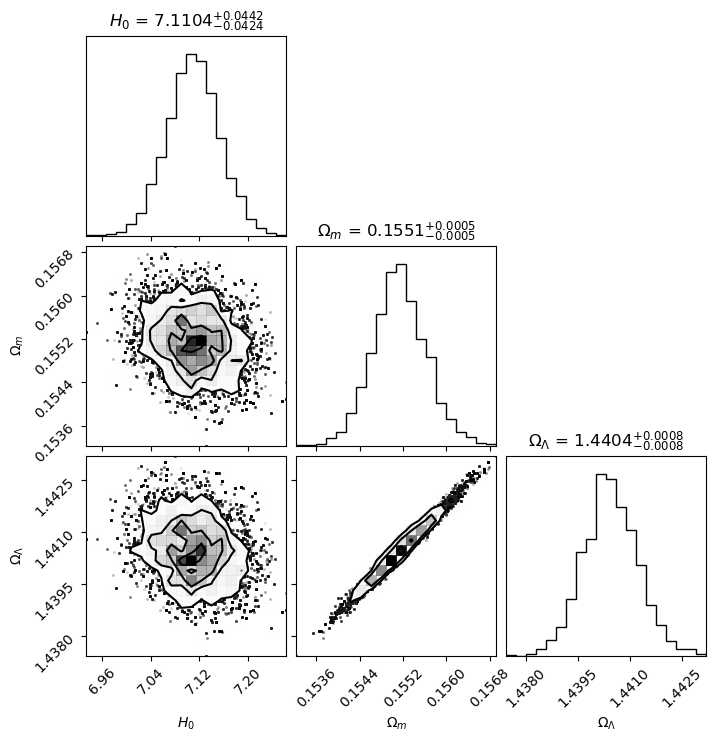

In [55]:
import corner
MCMC_fin_curved = np.load('MCMC_fin_curved_BAO.npy')
MCMC_fin_curved = MCMC_fin_curved[:,2000:]
# MCMC_fin에서 파라미터(H0, Omega_m)만 추출 (loglikelihood 제외)
samples = MCMC_fin_curved[:3].T  # shape: (샘플 수, 2)

figure = corner.corner(
    samples,
    labels=[r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"],
    show_titles=True,
    title_fmt=".4f",
    title_kwargs={"fontsize": 12}
)
plt.savefig('corner_plot_MCMC_SN+BAO_curved.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
accept_ratio = np.unique(MCMC_test).shape[0] / (nstep-800)
Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0:3], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Hubble constant : {Best_fit[0]}, Omega m : {Best_fit[1]}, Omega_lambda : {Best_fit[2]}')
print(f'std = {std}')

# 3. Nested Sampling
## 3-1. Flat LCDM

In [ ]:
import nestle
